# Proyecto ML: Modelo predictivo de precios de coche.

## 1. Introducción.

## 2. Obtención y procesado de datos.

Para la obtención de datos, realizaremos un WebScrapping de la página web de [https://www.coches.net](https://www.coches.net/segunda-mano/?MakeIds%5B0%5D=47&ModelIds%5B0%5D=0). Primero lo realizaremos sólo de la marca VolksWagen, por si nos limitan el acceso a los datos.

In [6]:
# !pip install beautifulsoup4
# !pip install selenium
# !pip install webdriver-manager

In [1]:
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

import time
import pandas as pd

import requests

Antes de realizar el WebScrapping y poblar la base de datos, debemos crearla. Hemos decicido crear una base de datos en local, utilizando SQLITE, ya que no dependemos de recursos externos y es suficiente para realizar los despliegues que queremos con Docker.

Creamos la conexión a la base de datos db_vehiculos:

In [3]:
# Importamos las librerías y miramos dónde está el kernel:

import sqlite3
import os

os.getcwd()

'c:\\Users\\alberto.pintos\\Documents\\Data Science\\Máster Big Data_UEMC-ENyD\\Contenidos Máster\\10. TFM\\TFM Alberto Pintos\\Código\\tfm_apintos_astro'

In [4]:
# Creamos la conexión a la base de datos:

con = sqlite3.connect("./include/db_vehiculos.db")

Escribimos la query para crear la tabla TX_VEHICULOS_SEG_MANO dentro de la base de datos db_vehiculos:

In [65]:
query = """

DROP TABLE TX_VEHICULOS_SEG_MANO;

"""

cursor = con.cursor()
cursor.execute(query)
con.commit()

In [67]:
query = """

CREATE TABLE IF NOT EXISTS TX_VEHICULOS_SEG_MANO (
    pk_anuncio_id INTEGER PRIMARY KEY,                       -- ID único del anuncio
    marca TEXT NOT NULL,                                     -- Marca del vehículo
    modelo TEXT NOT NULL,                                    -- Modelo del vehículo
    precio REAL,                                             -- Precio en euros
    combustible TEXT,                                        -- Tipo de combustible
    anyo_vehiculo INTEGER,                                   -- Año de matriculación
    kilometraje INTEGER,                                     -- Kilometraje en km
    potencia INTEGER,                                        -- Potencia en CV
    num_puertas INTEGER,                                     -- Número de puertas
    num_plazas INTEGER,                                      -- Número de plazas
    tipo_cambio TEXT,                                        -- Manual, automático, etc.
    tipo_vehiculo TEXT,                                      -- SUV, berlina, etc.
    cilindrada_motor INTEGER,                                -- En centímetros cúbicos
    color TEXT,                                              -- Color principal
    provincia TEXT,                                          -- Provincia del anuncio
    etiqueta_eco TEXT,                                       -- CERO, ECO, C, B...
    origen_anuncio TEXT,                                     -- Origen del anuncio: WebScraping,
    fecha_publicacion DATE,                                  -- Fecha real del anuncio
    anyomes_publicacion INTEGER,                             -- YYYYMM para particionado
    fecha_carga TIMESTAMP DEFAULT CURRENT_TIMESTAMP,         -- Fecha de carga al sistema
    url TEXT NOT NULL UNIQUE                                 -- URL completa del anuncio
);

"""

In [68]:
# Ejecutamos la query anterior:

cursor = con.cursor()
cursor.execute(query)

In [69]:
# Commiteamos los cambios en la bbdd:

con.commit()

In [70]:
# Creamos un índice por anyomes de publicación para acelerar consultas:

query = """

CREATE INDEX idx_anyomes_publicacion ON
 TX_VEHICULOS_SEG_MANO (anyomes_publicacion);

"""

cursor = con.cursor()
cursor.execute(query)
con.commit()

In [71]:
# Vamos a ver qué nos devuelve un select sobre la tabla:
query = """
SELECT * FROM TX_VEHICULOS_SEG_MANO;
"""

# Leemos los resultados en un DataFrame de pandas
df = pd.read_sql_query(query, con)

# Mostramos los primeros registros (aún no hay):
df

Empty DataFrame
Columns: [pk_anuncio_id, marca, modelo, precio, combustible, anyo_vehiculo, kilometraje, potencia, num_puertas, num_plazas, tipo_cambio, tipo_vehiculo, cilindrada_motor, color, provincia, etiqueta_eco, origen_anuncio, fecha_publicacion, anyomes_publicacion, fecha_carga, url]
Index: []

[0 rows x 21 columns]

Vemos que la tabla ya está creada, aunque de momento se encuentra vacía.

Realizamos el WebScraping utilizando BeautifulSoup y Selenium:

In [5]:
import requests
from bs4 import BeautifulSoup as bs
import time
import random
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

from selenium.webdriver.chrome.options import Options

USER_AGENTS = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.1 Safari/605.1.15",
    "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:99.0) Gecko/20100101 Firefox/99.0",
]


In [6]:
# Creamos una función con configuración para el Webdriver para evitar bans:

def get_driver_with_random_user_agent():
    user_agent = random.choice(USER_AGENTS)

    chrome_options = Options()
    chrome_options.add_argument(f"user-agent={user_agent}")
    chrome_options.add_argument("--disable-blink-features=AutomationControlled")  # más stealth
    # chrome_options.add_argument("--headless")  # si no quieres abrir ventana
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")

    driver = webdriver.Chrome(options=chrome_options)
    return driver


In [7]:
driver = get_driver_with_random_user_agent()

url = "https://www.coches.net/segunda-mano/?MakeIds%5B0%5D=7&ModelIds%5B0%5D=0"

driver.get(url)

In [12]:
# Automatizamos el aceptar las cookies:

Cookies = driver.find_element(By.XPATH, "/html/body/div[1]/div/div/div/div/div/div[3]/button[3]")

Cookies.click()

In [10]:
# Cogemos toda la info de la página actual:

soup = bs(driver.page_source,"lxml")

soup

<html data-env="production" lang="es-Es"><head><link href="https://s.ccdn.es/MotorStyles.a18b8c40.css" rel="stylesheet"/><link href="https://s.ccdn.es/AdsList.33be2d83.css" rel="stylesheet"/><!-- EXTERNAL SCRIPTS --><link href="https://s.ccdn.es" rel="preconnect dns-prefetch"/><link crossorigin="" href="https://cdn.segment.com" rel="preconnect dns-prefetch"/><link crossorigin="" href="https://api.segment.io" rel="preconnect dns-prefetch"/><link crossorigin="" href="https://cdns.gigya.com" rel="preconnect dns-prefetch"/><link crossorigin="" href="https://cdns.eu1.gigya.com" rel="preconnect dns-prefetch"/><!-- /EXTERNAL SCRIPTS --><link as="font" crossorigin="" href="https://s.ccdn.es/fonts/PoppinsMotor-400.woff2" rel="preload" type="font/woff2"/><link as="font" crossorigin="" href="https://s.ccdn.es/fonts/PoppinsMotor-600.woff2" rel="preload" type="font/woff2"/><link href="https://s.ccdn.es/images/coches/icons/favicon-16x16.png" rel="icon" sizes="16x16"/><link href="https://s.ccdn.es/im

In [ ]:
# Buscamos los datos del div que contiene el id del vehículo:

lista_div_id_vehiculos = soup.select('div[data-ad-id]') #div.data-ad-id')

lista_div_id_vehiculos

[<div data-ad-id="59365791" data-ad-position="0"><div class="mt-AnimationFadeOut mt-ListAds-item mt-CardAd mt-CardBasic"><div class="sui-AtomCard sui-AtomCard-link sui-AtomCard-link" role="button"><div class="sui-AtomCard-media"><div class="mt-CardAd-mediaContainer"><div class="mt-CardAd-media"><div class="mt-GalleryBasic" data-testid="gallery-basic-wrapper"><div class="mt-GalleryBasic-sliderWrapper" data-testid="gallery-basic-main-slider"><div class="mt-GalleryBasic-slider"><div class="sui-MoleculeCarousel sui-MoleculeCarousel--fullWidth sui-MoleculeCarousel--image-object-fit-contains"><button aria-label="Previous" class="mt-GalleryBasic-arrow mt-GalleryBasic-arrowLeft mt-GalleryBasic-prev" type="button"></button><button aria-label="Next" class="mt-GalleryBasic-arrow mt-GalleryBasic-arrowRight mt-GalleryBasic-next" type="button"></button><div><ul class="mt-GalleryBasic-itemsList" style="transition-timing-function: ease;transition-duration: 500ms;transform: translate3d(0%, 0px, 0px);">

In [23]:
lista_id_vehiculos = [div["data-ad-id"] for div in soup.select('div[data-ad-id]')]

lista_id_vehiculos

['59365791',
 '58742047',
 '60502354',
 '60169811',
 '60309932',
 '60447961',
 '60447961',
 '60523615',
 '60523615',
 '60523538',
 '60523538',
 '60523488',
 '60523488',
 '60523724',
 '60523724',
 '60522844',
 '60522844',
 '60522110',
 '60522110',
 '60523825',
 '60523825',
 '60523392',
 '60523392',
 '60418197',
 '60418197',
 '60494129',
 '60494129',
 '60273829',
 '60273829',
 '60319817',
 '60319817',
 '60433347',
 '60433347',
 '60522474',
 '60522474',
 '60523404',
 '60523404',
 '60475283',
 '60475283',
 '60512350',
 '60512350',
 '59891214',
 '59891214',
 '59398410',
 '59398410',
 '60522614',
 '60522614',
 '60157269',
 '60157269',
 '60523243',
 '60523243',
 '60438807',
 '60438807',
 '60522875',
 '60522875',
 '60147220',
 '60147220',
 '60317305',
 '60317305',
 '60027743',
 '60027743',
 '60522107',
 '60522107',
 '60411576',
 '60411576']

In [ ]:
# Obtiene el ID y la URL, pero solo funciona para los 5 primeros, los otros tienen otra estructura
# y no veo la URL.

for div in soup.select('div[data-ad-id]'):
    ad_id = div["data-ad-id"]

    # Busca el primer <a> dentro de ese div
    a_tag = div.find("a", href=True)
    if a_tag:
        relative_url = a_tag["href"]
        full_url = f"https://www.coches.net{relative_url}"

        print(f"ID: {ad_id}, URL: {full_url}")


ID: 59365791, URL: https://www.coches.net/bmw-x1-xdrive20da-5p-diesel-2022-en-orense-59365791-covo.aspx
ID: 58742047, URL: https://www.coches.net/bmw-serie-1-118i-5p-gasolina-2020-en-albacete-58742047-covo.aspx
ID: 60502354, URL: https://www.coches.net/bmw-serie-5-520d-efficient-dynamics-4p-diesel-2018-en-madrid-60502354-covo.aspx
ID: 60169811, URL: https://www.coches.net/bmw-i3-s-94ah-5p-electrico-hibrido-2018-en-malaga-60169811-covo.aspx
ID: 60309932, URL: https://www.coches.net/bmw-serie-3-330d-auto-touring-5p-diesel-2012-en-vizcaya-60309932-covo.aspx


Viendo esto, creo que voy a obtener solo el ID en esta página principal. Entrar en cada uno de los enlaces correspondientes al coche y sacar todos los datos de la nueva pestaña, como la url, año, kms, etc. Después volver atrás y hacerlo con el siguiente y así para cada id. Si el id ya está en la base de datos, que no entre.

In [28]:
anuncio_vehiculo = driver.find_element(By.XPATH, "/html/body/div[2]/div/div[2]/div[1]/div[1]/main/div[4]/section/div[1]/div[1]/div/div")

anuncio_vehiculo.click()

In [ ]:
# Obtenemos la url del vehículo particular:

url_actual = driver.current_url

url_actual

'https://www.coches.net/bmw-serie-3-318i-4p-gasolina-2007-en-madrid-60203006-covo.aspx'

<html data-env="production" lang="es-Es"><head><link href="https://s.ccdn.es/MotorStyles.a18b8c40.css" rel="stylesheet"/><link href="https://s.ccdn.es/AdsList.33be2d83.css" rel="stylesheet"/><!-- EXTERNAL SCRIPTS --><link href="https://s.ccdn.es" rel="preconnect dns-prefetch"/><link crossorigin="" href="https://cdn.segment.com" rel="preconnect dns-prefetch"/><link crossorigin="" href="https://api.segment.io" rel="preconnect dns-prefetch"/><link crossorigin="" href="https://cdns.gigya.com" rel="preconnect dns-prefetch"/><link crossorigin="" href="https://cdns.eu1.gigya.com" rel="preconnect dns-prefetch"/><!-- /EXTERNAL SCRIPTS --><link as="font" crossorigin="" href="https://s.ccdn.es/fonts/PoppinsMotor-400.woff2" rel="preload" type="font/woff2"/><link as="font" crossorigin="" href="https://s.ccdn.es/fonts/PoppinsMotor-600.woff2" rel="preload" type="font/woff2"/><link href="https://s.ccdn.es/images/coches/icons/favicon-16x16.png" rel="icon" sizes="16x16"/><link href="https://s.ccdn.es/im
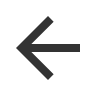
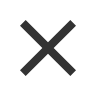
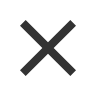

In [30]:
soup_vehiculo = bs(driver.page_source,"lxml")

soup_vehiculo

In [ ]:
# Cogemos la marca y modelo del vehículo:

title_element = soup_vehiculo.select_one('h1.mt-TitleBasic-title')
marca_y_modelo = title_element.get_text(strip=True)

palabras = marca_y_modelo.split(" ")
marca_vehiculo = palabras[0]
modelo_vehiculo = " ".join(palabras[1:])

print(marca_vehiculo)
print(modelo_vehiculo)


BMW
Serie 3 318I


In [49]:
# Cogemos la tabla de datos del vehículo:

tabla_datos_vehiculo = soup_vehiculo.select('ul.mt-PanelAdDetails-data li.mt-PanelAdDetails-dataItem')

tabla_datos_vehiculo

[<li class="mt-PanelAdDetails-dataItem"><strong>2007</strong></li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>209.000</strong> km</li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>Madrid</strong></li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>Berlina</strong></li>,
 <li class="mt-PanelAdDetails-dataItem">Cambio <strong>Manual</strong></li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>4</strong> Puertas</li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>5</strong> Plazas</li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>1995</strong> cc</li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>129</strong> cv</li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>Negro</strong></li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>Gasolina</strong></li>,
 <li class="mt-PanelAdDetails-dataItem"></li>]

In [77]:
# Transformamos y gurdamos los datos en variables:

import re

lista_datos_vehiculo = [li.get_text(strip=True) for li in tabla_datos_vehiculo]

anyo = lista_datos_vehiculo[0]
kms = re.sub(r"[^\d]", "", lista_datos_vehiculo[1])  # elimina puntos, espacios y 'km'
provincia = lista_datos_vehiculo[2]
carroceria = lista_datos_vehiculo[3]
cambio = lista_datos_vehiculo[4].replace("Cambio", "")
puertas = re.search(r"\d+", lista_datos_vehiculo[5]).group() if re.search(r"\d+", lista_datos_vehiculo[5]) else None
plazas = re.search(r"\d+", lista_datos_vehiculo[6]).group() if re.search(r"\d+", lista_datos_vehiculo[6]) else None
cilindrada = re.search(r"\d+", lista_datos_vehiculo[7]).group() if re.search(r"\d+", lista_datos_vehiculo[7]) else None
potencia = re.search(r"\d+", lista_datos_vehiculo[8]).group() if re.search(r"\d+", lista_datos_vehiculo[8]) else None
color = lista_datos_vehiculo[9]
combustible = lista_datos_vehiculo[10]


In [ ]:
# Comprobamos el formato de los datos que se guardan:

print(f"Año: {anyo}")
print(f"Kms: {kms}")
print(f"Provincia: {provincia}")
print(f"Carrocería: {carroceria}")
print(f"Cambio: {cambio}")
print(f"Puertas: {puertas}")
print(f"Plazas: {plazas}")
print(f"Cilindrada (cc): {cilindrada}")
print(f"Potencia (CV): {potencia}")
print(f"Color: {color}")
print(f"Combustible: {combustible}")

In [ ]:
# Transformamos y gurdamos los datos en variables:

import re

lista_datos_vehiculo = [li.get_text(strip=True) for li in tabla_datos_vehiculo]


for item in lista_datos_vehiculo:
    texto = item.get_text(strip=True).lower()

    if "km" in texto:
        kms = re.sub(r"[^\d]", "", texto)
    elif "puerta" in texto:
        puertas = re.search(r"\d+", texto).group()
    elif "plaza" in texto:
        plazas = re.search(r"\d+", texto).group()
    elif "cc" in texto:
        cilindrada = re.search(r"\d+", texto).group()
    elif "cv" in texto:
        potencia = re.search(r"\d+", texto).group()
    elif "gasolina" in texto or "diesel" in texto or "eléctrico" in texto:
        combustible = texto.title()
    elif "cambio" in texto:
        cambio = texto.replace("cambio", "").strip().title()
    elif "berlina" in texto or "suv" in texto or "familiar" in texto:
        carroceria = texto.title()
    elif texto in ["madrid", "barcelona", "sevilla", "valencia"]:  # etc
        ciudad = texto.title()
    elif texto.isdigit() and len(texto) == 4:  # Año típico
        anio = texto
    elif "negro" in texto or "blanco" in texto or "gris" in texto:
        color = texto.title()


Año: 2007
Kms: 209000
Provincia: Madrid
Carrocería: Berlina
Cambio: Manual
Puertas: 4
Plazas: 5
Cilindrada (cc): 1995
Potencia (CV): 129
Color: Negro
Combustible: Gasolina


Hay algunos vehículos que tienen más campos en esta tabla, por lo que vamos a probar con uno para hacer el código lo más consistente posible.

In [ ]:
# Obtenemos la url del vehículo particular con el máximo de campos:

import time

url_actual = driver.current_url

time.sleep(120)

url_actual

'https://www.coches.net/bmw-serie-1-116d-5p-diesel-2020-en-granada-60416668-covo.aspx'

<html data-env="production" lang="es-Es"><head><link href="https://s.ccdn.es/MotorStyles.a18b8c40.css" rel="stylesheet"/><link href="https://s.ccdn.es/AdsList.33be2d83.css" rel="stylesheet"/><!-- EXTERNAL SCRIPTS --><link href="https://s.ccdn.es" rel="preconnect dns-prefetch"/><link crossorigin="" href="https://cdn.segment.com" rel="preconnect dns-prefetch"/><link crossorigin="" href="https://api.segment.io" rel="preconnect dns-prefetch"/><link crossorigin="" href="https://cdns.gigya.com" rel="preconnect dns-prefetch"/><link crossorigin="" href="https://cdns.eu1.gigya.com" rel="preconnect dns-prefetch"/><!-- /EXTERNAL SCRIPTS --><link as="font" crossorigin="" href="https://s.ccdn.es/fonts/PoppinsMotor-400.woff2" rel="preload" type="font/woff2"/><link as="font" crossorigin="" href="https://s.ccdn.es/fonts/PoppinsMotor-600.woff2" rel="preload" type="font/woff2"/><link href="https://s.ccdn.es/images/coches/icons/favicon-16x16.png" rel="icon" sizes="16x16"/><link href="https://s.ccdn.es/im
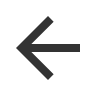
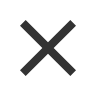
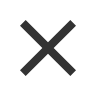

In [16]:
# Coche con el máximo de campos:

soup_vehiculo_max = bs(driver.page_source,"lxml")

time.sleep(300)

soup_vehiculo_max

In [18]:
# Cogemos la marca y modelo del vehículo:

title_element = soup_vehiculo_max.select_one('h1.mt-TitleBasic-title')
marca_y_modelo = title_element.get_text(strip=True)

palabras = marca_y_modelo.split(" ")
marca_vehiculo = palabras[0]
modelo_vehiculo = " ".join(palabras[1:])

print(marca_vehiculo)
print(modelo_vehiculo)

BMW
Serie 1 116d


In [20]:
# Cogemos la tabla de datos del vehículo:

tabla_datos_vehiculo = soup_vehiculo_max.select('ul.mt-PanelAdDetails-data li.mt-PanelAdDetails-dataItem')

tabla_datos_vehiculo

[<li class="mt-PanelAdDetails-dataItem"><strong>2020</strong></li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>59.918</strong> km</li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>Granada</strong></li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>Berlina</strong></li>,
 <li class="mt-PanelAdDetails-dataItem">Cambio <strong>Manual</strong></li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>5</strong> Puertas</li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>5</strong> Plazas</li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>1496</strong> cc</li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>116</strong> cv</li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>Negro</strong></li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>100</strong> gr/km</li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>Diesel</strong></li>,
 <li class="mt-PanelAdDetails-dataItem">Garantía <strong>12 meses (1 año)</strong></li>,
 <li class="mt-PanelAdDetails-dataItem"><div class="m

In [ ]:
import re

def extraer_datos_tecnicos(tabla_datos_vehiculo):
    # Paso 1: Campos fijos (0 a 6)
    anyo = tabla_datos_vehiculo[0].get_text(strip=True)
    kms = re.sub(r"[^\d]", "", tabla_datos_vehiculo[1].get_text(strip=True))
    ciudad = tabla_datos_vehiculo[2].get_text(strip=True)
    carroceria = tabla_datos_vehiculo[3].get_text(strip=True)
    cambio = tabla_datos_vehiculo[4].get_text(strip=True).replace("Cambio", "").strip()
    puertas = re.search(r"\d+", tabla_datos_vehiculo[5].get_text()).group()
    plazas = re.search(r"\d+", tabla_datos_vehiculo[6].get_text()).group()

    # Inicializar campos opcionales
    cilindrada = potencia = color = emisiones = combustible = garantia = etiqueta = None

    colores_posibles = ["negro", "blanco", "rojo", "gris", "azul", "verde", "marrón", "beige", "naranja", "amarillo", "plateado"]

    for item in tabla_datos_vehiculo[7:]:
        texto = item.get_text(strip=True)
        texto_lower = texto.lower()

        if "cc" in texto_lower:
            cilindrada = re.search(r"\d+", texto).group()
        elif "cv" in texto_lower:
            potencia = re.search(r"\d+", texto).group()
        elif any(color_pos in texto_lower for color_pos in colores_posibles) and "etiqueta" not in texto_lower:
            color = texto
        elif "gr/km" in texto_lower:
            emisiones = re.search(r"\d+", texto).group()
        elif any(x in texto_lower for x in ["diesel", "gasolina", "eléctrico", "híbrido", "hibrido enchufable"]):
            combustible = texto.title()
        elif "garantía" in texto_lower:
            garantia = re.sub(r"garantía\s*", "", texto, flags=re.IGNORECASE).strip()
        elif "etiqueta" in texto_lower:
            etiqueta = re.sub(r"etiqueta\s*", "", texto, flags=re.IGNORECASE).strip()

    return {
        "anyo": anyo,
        "kms": kms,
        "ciudad": ciudad,
        "carroceria": carroceria,
        "cambio": cambio,
        "puertas": puertas,
        "plazas": plazas,
        "cilindrada": cilindrada,
        "potencia": potencia,
        "color": color,
        "emisiones": emisiones,
        "combustible": combustible,
        "garantia": garantia,
        "etiqueta": etiqueta
    }



In [26]:
extraer_datos_tecnicos(tabla_datos_vehiculo)

{'anyo': '2020',
 'kms': '59918',
 'ciudad': 'Granada',
 'carroceria': 'Berlina',
 'cambio': 'Manual',
 'puertas': '5',
 'plazas': '5',
 'cilindrada': '1496',
 'potencia': '116',
 'color': 'Negro',
 'emisiones': '100',
 'combustible': 'Diesel',
 'garantia': '12 meses (1 año)',
 'etiqueta': 'C (verde)'}

In [19]:
# Guardo el contenido html de la variable soup_vehiculo_max:

with open("./include/archivos_html/soup_vehiculo_max.html", "w", encoding="utf-8") as f:
    f.write(str(soup_vehiculo_max))


Abrimos la página html del vehículo guardada en local, para ajustar la obtención del resto de datos (vamos a obtener todos):

<html data-env="production" lang="es-Es"><head><link href="https://s.ccdn.es/MotorStyles.a18b8c40.css" rel="stylesheet"/><link href="https://s.ccdn.es/AdsList.33be2d83.css" rel="stylesheet"/><!-- EXTERNAL SCRIPTS --><link href="https://s.ccdn.es" rel="preconnect dns-prefetch"/><link crossorigin="" href="https://cdn.segment.com" rel="preconnect dns-prefetch"/><link crossorigin="" href="https://api.segment.io" rel="preconnect dns-prefetch"/><link crossorigin="" href="https://cdns.gigya.com" rel="preconnect dns-prefetch"/><link crossorigin="" href="https://cdns.eu1.gigya.com" rel="preconnect dns-prefetch"/><!-- /EXTERNAL SCRIPTS --><link as="font" crossorigin="" href="https://s.ccdn.es/fonts/PoppinsMotor-400.woff2" rel="preload" type="font/woff2"/><link as="font" crossorigin="" href="https://s.ccdn.es/fonts/PoppinsMotor-600.woff2" rel="preload" type="font/woff2"/><link href="https://s.ccdn.es/images/coches/icons/favicon-16x16.png" rel="icon" sizes="16x16"/><link href="https://s.ccdn.es/im
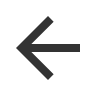
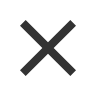
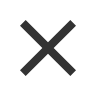

In [20]:
from bs4 import BeautifulSoup

with open("./include/archivos_html/soup_vehiculo_max.html", "r", encoding="utf-8") as f:
    html = f.read()

soup_vehiculo_max = BeautifulSoup(html, "html.parser")

soup_vehiculo_max

### 1. Marca, modelo y precio:

In [ ]:
title_element = soup_vehiculo_max.select_one('h1.mt-TitleBasic-title')
marca_y_modelo = title_element.get_text(strip=True)

palabras = marca_y_modelo.split(" ")
marca_vehiculo = palabras[0]
modelo_vehiculo = " ".join(palabras[1:])

print(marca_vehiculo)
print(modelo_vehiculo)

BMW
Serie 1 116d


In [63]:
string_precio = soup_vehiculo_max.find("p", class_="mt-CardAdPrice-cashAmount")

if string_precio:
    texto_precio = string_precio.text.strip().replace('.', '').replace('€', '').strip()
    try:
        precio = float(texto_precio)
    except ValueError:
        precio = None  # o maneja el error como necesites
else:
    precio = None

precio

19990.0

### 2. Datos principales de la tabla de datos:

In [50]:
# Cogemos la tabla de datos del vehículo:

tabla_datos_vehiculo = soup_vehiculo_max.select('ul.mt-PanelAdDetails-data li.mt-PanelAdDetails-dataItem')

tabla_datos_vehiculo

[<li class="mt-PanelAdDetails-dataItem"><strong>2020</strong></li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>59.918</strong> km</li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>Granada</strong></li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>Berlina</strong></li>,
 <li class="mt-PanelAdDetails-dataItem">Cambio <strong>Manual</strong></li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>5</strong> Puertas</li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>5</strong> Plazas</li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>1496</strong> cc</li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>116</strong> cv</li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>Negro</strong></li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>100</strong> gr/km</li>,
 <li class="mt-PanelAdDetails-dataItem"><strong>Diesel</strong></li>,
 <li class="mt-PanelAdDetails-dataItem">Garantía <strong>12 meses (1 año)</strong></li>,
 <li class="mt-PanelAdDetails-dataItem"><div class="m

In [51]:
import re

def extraer_datos_tecnicos(tabla_datos_vehiculo):
    # Paso 1: Campos fijos (0 a 6)
    anyo = tabla_datos_vehiculo[0].get_text(strip=True)
    kms = re.sub(r"[^\d]", "", tabla_datos_vehiculo[1].get_text(strip=True))
    ciudad = tabla_datos_vehiculo[2].get_text(strip=True)
    carroceria = tabla_datos_vehiculo[3].get_text(strip=True)
    cambio = tabla_datos_vehiculo[4].get_text(strip=True).replace("Cambio", "").strip()
    puertas = re.search(r"\d+", tabla_datos_vehiculo[5].get_text()).group()
    plazas = re.search(r"\d+", tabla_datos_vehiculo[6].get_text()).group()

    # Inicializar campos opcionales
    cilindrada = potencia = color = emisiones = combustible = garantia = etiqueta = None

    colores_posibles = ["negro", "blanco", "rojo", "gris", "azul", "verde", "marrón", "beige", "naranja", "amarillo", "plateado"]

    for item in tabla_datos_vehiculo[7:]:
        texto = item.get_text(strip=True)
        texto_lower = texto.lower()

        if "cc" in texto_lower:
            cilindrada = re.search(r"\d+", texto).group()
        elif "cv" in texto_lower:
            potencia = re.search(r"\d+", texto).group()
        elif any(color_pos in texto_lower for color_pos in colores_posibles) and "etiqueta" not in texto_lower:
            color = texto
        elif "gr/km" in texto_lower:
            emisiones = re.search(r"\d+", texto).group()
        elif any(x in texto_lower for x in ["diesel", "gasolina", "eléctrico", "híbrido", "hibrido enchufable"]):
            combustible = texto.title()
        elif "garantía" in texto_lower:
            garantia = re.sub(r"garantía\s*", "", texto, flags=re.IGNORECASE).strip()
        elif "etiqueta" in texto_lower:
            etiqueta = re.sub(r"etiqueta\s*", "", texto, flags=re.IGNORECASE).strip()

    return {
        "anyo": anyo,
        "kms": kms,
        "ciudad": ciudad,
        "carroceria": carroceria,
        "cambio": cambio,
        "puertas": puertas,
        "plazas": plazas,
        "cilindrada": cilindrada,
        "potencia": potencia,
        "color": color,
        "emisiones": emisiones,
        "combustible": combustible,
        "garantia": garantia,
        "etiqueta": etiqueta
    }


In [52]:
extraer_datos_tecnicos(tabla_datos_vehiculo)

{'anyo': '2020',
 'kms': '59918',
 'ciudad': 'Granada',
 'carroceria': 'Berlina',
 'cambio': 'Manual',
 'puertas': '5',
 'plazas': '5',
 'cilindrada': '1496',
 'potencia': '116',
 'color': 'Negro',
 'emisiones': '100',
 'combustible': 'Diesel',
 'garantia': '12 meses (1 año)',
 'etiqueta': 'C (verde)'}

### 3. Datos extra:

In [49]:
from datetime import datetime

# Obtener la fecha actual
hoy = datetime.now()
fecha_actual = hoy.strftime("%d/%m")

# Extraer la fecha del anuncio
string_fecha_publicacion = soup_vehiculo_max.find("p", class_="mt-PanelAdInfo-published")

if string_fecha_publicacion:
    texto = string_fecha_publicacion.text.strip()
    fecha_str = texto.split(",")[0].replace("Publicado: ", "").strip()[0:5]  # 'DD/MM'

    # Convertimos ambas fechas en objetos datetime para comparar
    fecha_publicacion_dt = datetime.strptime(fecha_str, "%d/%m")
    fecha_actual_dt = datetime.strptime(fecha_actual, "%d/%m")

    # Decidir el año
    if fecha_publicacion_dt > fecha_actual_dt:
        año = hoy.year - 1
    else:
        año = hoy.year

    # Construimos la fecha final con el año correcto
    fecha_final_publicacion = datetime.strptime(f"{fecha_str}/{año}", "%d/%m/%Y").date()

    anyomes_publicacion = f"{año}{fecha_publicacion_dt.month:02d}"

    print(fecha_final_publicacion)
    print(anyomes_publicacion)


2025-04-25
202504


### Recopilamos todas las variables:

In [72]:
id_vehiculo = 60416668
url_vehiculo = 'https://www.coches.net/bmw-serie-1-116d-5p-diesel-2020-en-granada-60416668-covo.aspx'

In [73]:
# 1. Anuncio, marca y modelo:

print(f"ID: {id_vehiculo}")
print(f"URL: {url_vehiculo}")

print(f"Marca: {marca_vehiculo}")
print(f"Modelo: {modelo_vehiculo}")
print(f"Precio: {precio}")

# 2. Datos principales:
dicc_datos_ppales = extraer_datos_tecnicos(tabla_datos_vehiculo)

for clave, valor in dicc_datos_ppales.items():
    print(f"{clave}: {valor}")

# 3. Fecha de publicación:
print(f"Fecha de publicación: {fecha_final_publicacion}")
print(f"Anyomes publicación: {anyomes_publicacion}")


ID: 60416668
URL: https://www.coches.net/bmw-serie-1-116d-5p-diesel-2020-en-granada-60416668-covo.aspx
Marca: BMW
Modelo: Serie 1 116d
Precio: 19990.0
anyo: 2020
kms: 59918
ciudad: Granada
carroceria: Berlina
cambio: Manual
puertas: 5
plazas: 5
cilindrada: 1496
potencia: 116
color: Negro
emisiones: 100
combustible: Diesel
garantia: 12 meses (1 año)
etiqueta: C (verde)
Fecha de publicación: 2025-04-25
Anyomes publicación: 202504


Faltarían estos campos para incorporarlos utilizando el ID de la página global de coches y la url del anuncio particular:

* pk_anuncio_id
* url

Cargamos los datos del vehículo en la BBDD:

In [74]:
import sqlite3

# Conexión a la base de datos (ajusta el nombre del archivo si es necesario)
conn = sqlite3.connect("./include/db_vehiculos.db")
cursor = conn.cursor()

# Inserción
consulta = """
INSERT OR IGNORE INTO TX_VEHICULOS_SEG_MANO (
    pk_anuncio_id,
    marca,
    modelo,
    precio,
    combustible,
    anyo_vehiculo,
    kilometraje,
    potencia,
    num_puertas,
    num_plazas,
    tipo_cambio,
    tipo_vehiculo,
    cilindrada_motor,
    color,
    provincia,
    etiqueta_eco,
    origen_anuncio,
    fecha_publicacion,
    anyomes_publicacion,
    url
) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
"""

valores = (
    id_vehiculo,
    marca_vehiculo,
    modelo_vehiculo,
    precio,
    dicc_datos_ppales.get("combustible"),
    int(dicc_datos_ppales.get("anyo")),
    int(dicc_datos_ppales.get("kms")),
    int(dicc_datos_ppales.get("potencia")),
    int(dicc_datos_ppales.get("puertas")),
    int(dicc_datos_ppales.get("plazas")),
    dicc_datos_ppales.get("cambio"),
    dicc_datos_ppales.get("carroceria"),
    int(dicc_datos_ppales.get("cilindrada")),
    dicc_datos_ppales.get("color"),
    dicc_datos_ppales.get("ciudad"),
    dicc_datos_ppales.get("etiqueta"),
    "WebScraping",
    fecha_final_publicacion,
    int(anyomes_publicacion),
    url_vehiculo
)

cursor.execute(consulta, valores)
conn.commit()
conn.close()


In [75]:
# Vamos a ver qué nos devuelve un select sobre la tabla:
query = """
SELECT * FROM TX_VEHICULOS_SEG_MANO;
"""

# Leemos los resultados en un DataFrame de pandas
df = pd.read_sql_query(query, con)

# Mostramos los primeros registros (aún no hay):
df

pk_anuncio_id marca        modelo   precio combustible  anyo_vehiculo  \
0       60416668   BMW  Serie 1 116d  19990.0      Diesel           2020   

   kilometraje  potencia  num_puertas  num_plazas  ... tipo_vehiculo  \
0        59918       116            5           5  ...       Berlina   

  cilindrada_motor  color provincia etiqueta_eco origen_anuncio  \
0             1496  Negro   Granada    C (verde)    WebScraping   

  fecha_publicacion anyomes_publicacion          fecha_carga  \
0        2025-04-25              202504  2025-05-11 11:12:48   

                                                 url  
0  https://www.coches.net/bmw-serie-1-116d-5p-die...  

[1 rows x 21 columns]

In [77]:
query_id = """
SELECT PK_ANUNCIO_ID
FROM TX_VEHICULOS_SEG_MANO
GROUP BY PK_ANUNCIO_ID;
"""

cursor = con.cursor()
cursor.execute(query_id)

# Obtener todos los resultados como una lista de tuplas
resultados = cursor.fetchall()

# Si quieres una lista simple con solo los IDs:
lista_ids = [fila[0] for fila in resultados]

lista_ids

[60416668]

In [ ]:
XPath_1_anuncio = /html/body/div[2]/div/div[2]/div[1]/div[1]/main/div[4]/section/div[1]/div[1]/div/div
XPath_2_anuncio = /html/body/div[2]/div/div[2]/div[1]/div[1]/main/div[4]/section/div[1]/div[2]/div/div

In [ ]:
id_anuncio_vehiculo = id_vehiculo
        anuncio_vehiculo = driver.find_element(By.XPATH, "/html/body/div[2]/div/div[2]/div[1]/div[1]/main/div[4]/section/div[1]/div[1]/div/div")


In [27]:
volver_atras = driver.back()